<a href="https://colab.research.google.com/github/marzione00/Association_analysis_and_tweets/blob/main/Tweets_association_analysis_vaccines_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries and tools

In [ ]:
!pip install pyspark
!pip install wget
import wget
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import collect_set
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
spark = SparkSession.builder.enableHiveSupport().getOrCreate()
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk, string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
import timeit

     |████████████████████████████████| 212.4 MB 51 kB/s 
     |████████████████████████████████| 198 kB 56.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=167a7e84b31235a361e86d9d88ce6f0636e77eb93dfdd359a3df7e2b36d13ec1
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=526f2de397263e8113cb4e9bfa2e38839fd43e0c8fc3c69818a3499721b0ea55
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Download the dataset

In [ ]:
!wget https://www.dropbox.com/sh/lcdpcgo2itw9d0s/AAC2b0kTei_3foLf0S7lEOfra?dl=1 --content-disposition
!unzip Tweet_rep.zip

--2021-09-23 14:56:46--  https://www.dropbox.com/sh/lcdpcgo2itw9d0s/AAC2b0kTei_3foLf0S7lEOfra?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/dl/lcdpcgo2itw9d0s/AAC2b0kTei_3foLf0S7lEOfra [following]
--2021-09-23 14:56:47--  https://www.dropbox.com/sh/dl/lcdpcgo2itw9d0s/AAC2b0kTei_3foLf0S7lEOfra
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0ddc905eed519f6c35f3115304.dl.dropboxusercontent.com/zip_download_get/A6Eidh5lb-gRkrnKvUZCVGlYpOx-pakEpahzVzTW6uckgl9iYbtXzuUVT-XMZb1cdNIB5udHiNZSeOaEP3F2yqtJgCcj44GDQm0SQgVFxkKW6g?dl=1# [following]
--2021-09-23 14:56:47--  https://uc0ddc905eed519f6c35f3115304.dl.dropboxusercontent.com/zip_download_get/A6Eidh5lb-gRkrnKvUZCVGlYpOx-pakEpahzVzTW6uckgl9iYbtXzuUVT-XMZb1cdNIB5udHiN

In [ ]:
tweets = pd.read_csv("2021-08-27vaccines.csv", sep="|")

Clean and tokenize the corpus

In [ ]:
tweets["tweet_text_tokenized"] = tweets["tweet_text"].astype(str).apply(nltk.word_tokenize)

In [ ]:
stop = stopwords.words("english") 
add= ["vaccines","vaccine"]
stop.extend(add)
boh = ["''","...", "``", "--"]
string.punctuaction = boh + list(string.punctuation)
tweets['tweet_without_stopwords'] = tweets.tweet_text.str.replace("[^\w\s]", "").str.lower()
tweets['tweet_without_stopwords'] = tweets['tweet_without_stopwords'].dropna().apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
tweets['tweet_without_stopwords'] = tweets['tweet_without_stopwords'].str.replace('[{}]'.format(string.punctuation), '')
tweets['tweet_without_stopwords'] = tweets['tweet_without_stopwords'].astype(str).apply(nltk.word_tokenize)

Create the cleaned baskets

In [ ]:
df = pd.DataFrame() 
lista = [] 
listb = []
for i in range (0,10000):
  for x in tweets.loc[i,"tweet_without_stopwords"]:
     lista.append(i)
     listb.append(x)
d = {'basket':lista,'item':listb}
dframe = pd.DataFrame(d)  

In [ ]:
dframe['item'].replace('', np.nan, inplace=True)

Inizialize spark session

In [ ]:
dframe.dropna(subset=['item'], inplace=True)
dframe_red=dframe.sample(n=1000)

In [ ]:
df_sp = spark.createDataFrame(dframe)
df_sp_red=spark.createDataFrame(dframe_red)

In [ ]:
df_sp.createOrReplaceTempView("df_sp")
df_sp.createOrReplaceTempView("dframe_red")

Show the sparse matrix

In [ ]:
df_sp_red.stat.crosstab("basket", "item").show(n=90)
plot_matrix=df_sp_red.stat.crosstab("basket", "item").toPandas()

+-----------+---+---+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+------+--------+------+------+-----------------+--------+-------+---+----------+-----------+--------------+-----------+--------+------+------------+------+--------+------------+-----------+-----------------+---+-----+---+-------+------------+-----+--------+----+------------+------+-------+-------+--------+---------+-----+---+---------+-------+----------+----------+-----------+------+------+--------+-----------+--------+--------+-----+----+------+------+----+------------+---------+---------+-----+---------+----+------+----+------------+----------+----------+-------------------+-------+-------+--------+---+------+-----+---+-------+-----------+----------+--------+---------+-----+-------+--------+------------+-----+-----+-------------+------------+--------+-----+-------+------+------------+----+------+-------------+---------+-------+---------------+--------+----+-----+----+------+---+------+--

In [ ]:
print(plot_matrix)
pp=plot_matrix.pivot_table(index=["basket_item"])
plt.figure(figsize=(360, 280))
sns.heatmap(pp)

    basket_item  1  14  16  16litre  19  ...  wrote  yale  year  yet  young  youre
0          8062  0   0   0        0   0  ...      0     0     0    0      0      0
1          9131  0   0   0        0   0  ...      0     0     0    0      0      0
2          8930  0   0   0        0   0  ...      0     0     0    0      0      0
3           138  0   0   0        0   0  ...      0     0     0    0      0      0
4          3345  0   0   0        0   0  ...      0     0     0    0      0      0
..          ... ..  ..  ..      ...  ..  ...    ...   ...   ...  ...    ...    ...
914        4940  0   0   0        0   0  ...      0     0     0    0      0      0
915         232  0   0   0        0   0  ...      0     0     0    0      0      0
916        6886  0   0   0        0   0  ...      0     0     0    0      0      0
917        8465  0   0   0        0   0  ...      0     0     0    0      0      0
918        8348  0   0   0        0   0  ...      0     0     0    0      0      0

[91

In [ ]:
plt.savefig("output.png")

<Figure size 432x288 with 0 Axes>

#FP-growth algorithm 
Solution adapted from [Tutoraggio: Market-basket analysis](https://malchiodi.di.unimi.it/teaching/AMD-DSE/2020-21/)

In [ ]:
baskets = df_sp.groupBy('basket').agg(collect_set('item').alias('items'))
baskets.createOrReplaceTempView('baskets')
baskets.toPandas().head()

,basket,items
0,26,"[follow, well, list, 62, covid19, climb, raise..."
1,29,"[vaccinepassport, tiktok]"
2,474,"[follow, well, list, covid19, climb, raise, we..."
3,964,"[fda, bloodclots, eligible, eua, bla, healthca..."
4,1677,"[ucla, universities, columbia, talk2study, inc..."


In [ ]:
!mkdir /content/drive/MyDrive/Output
drive.mount("/content/drive",force_remount=True)
base_path = "/content/drive/MyDrive/Output/"


mkdir: cannot create directory ‘/content/drive/MyDrive/Output’: No such file or directory
Mounted at /content/drive


Display frequent itemsets

In [ ]:
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.03, minConfidence=0)
model = fpGrowth.fit(baskets)

In [ ]:
mostPopularItemInABasket = model.freqItemsets
mostPopularItemInABasket.createOrReplaceTempView("mostPopularItemInABasket")
output_mostPopularItemInABasket=mostPopularItemInABasket.toPandas()
output_mostPopularItemInABasket.sort_values(by=["freq"],ascending=False).to_excel(base_path + "output_mostPopularItemInABasket_vaccines.xlsx")
mostPopularItemInABasket.orderBy("freq",ascending=False).show(truncate=False,n=100)

+----------------------+----+
|items                 |freq|
+----------------------+----+
|[covid19]             |4007|
|[covid]               |1596|
|[amp]                 |1080|
|[get]                 |965 |
|[people]              |755 |
|[vaccinated]          |740 |
|[pfizer]              |720 |
|[need]                |634 |
|[vaccination]         |598 |
|[health]              |573 |
|[us]                  |560 |
|[pandemic]            |521 |
|[fda]                 |507 |
|[dont]                |501 |
|[new]                 |462 |
|[well]                |451 |
|[news]                |442 |
|[covid, covid19]      |435 |
|[coronavirus]         |433 |
|[pfizer, covid19]     |426 |
|[please]              |415 |
|[moderna]             |399 |
|[amp, covid19]        |398 |
|[need, covid19]       |396 |
|[list]                |391 |
|[masks]               |383 |
|[get, covid19]        |363 |
|[know]                |357 |
|[like]                |354 |
|[many]                |346 |
|[one]    

In [ ]:
sns.set_style("darkgrid")
sns.set(rc = {'figure.figsize':(15,8)})
sns.set(font_scale = 2)

<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

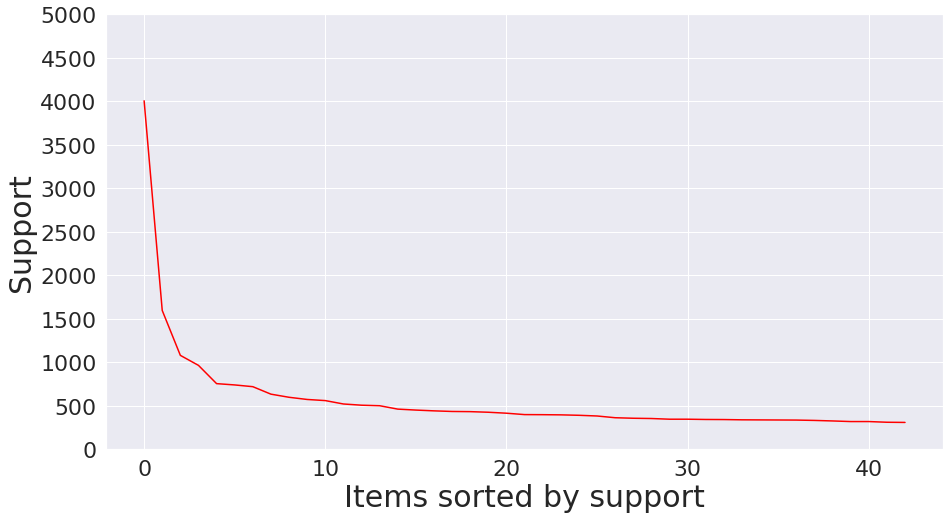

In [ ]:
plot=pd.DataFrame(output_mostPopularItemInABasket[["freq"]].sort_values("freq",ascending=False))
plot["items_sorted"]=range(0, len(output_mostPopularItemInABasket))

cool_plot=sns.lineplot(data=plot,y=plot.freq,x=plot.items_sorted,color='red')
cool_plot.set_xlabel("Items sorted by support",fontsize=30)
cool_plot.set_ylabel("Support",fontsize=30)
cool_plot.set_yticks(range(0, 5500, 500))

sns

In [ ]:
import scipy.integrate as integrate

In [ ]:
area=plot.apply(integrate.trapz)
area

freq            22347.0
items_sorted      882.0
dtype: float64

Display generated association rules

In [ ]:
associationRules = model.associationRules
associationRules.createOrReplaceTempView("associationRules")
output_associationRules=associationRules.toPandas()

output_associationRules.sort_values(by=["support"],ascending=False).to_excel(base_path + "output_associationRules_vaccines.xlsx")  

associationRules.orderBy("lift",ascending=False).show(truncate=False,n=100)



+-------------+-------------+-------------------+------------------+-------+
|antecedent   |consequent   |confidence         |lift              |support|
+-------------+-------------+-------------------+------------------+-------+
|[please]     |[covid19]    |0.7855421686746988 |1.9604246784993733|0.0326 |
|[covid19]    |[please]     |0.08135762415772398|1.9604246784993729|0.0326 |
|[news]       |[covid19]    |0.7647058823529411 |1.9084249621985054|0.0338 |
|[covid19]    |[news]       |0.08435238332917394|1.9084249621985052|0.0338 |
|[well]       |[covid19]    |0.7361419068736141 |1.8371397725820169|0.0332 |
|[covid19]    |[well]       |0.08285500374344897|1.8371397725820169|0.0332 |
|[pandemic]   |[covid19]    |0.6583493282149712 |1.6429980739080887|0.0343 |
|[covid19]    |[pandemic]   |0.08560019965061143|1.6429980739080887|0.0343 |
|[need]       |[covid19]    |0.6246056782334385 |1.5587863195244285|0.0396 |
|[covid19]    |[need]       |0.09882705265784876|1.5587863195244285|0.0396 |

Transform examines the input items against all the association rules and summarize the consequents as prediction

In [ ]:
associations = model.transform(baskets)
output_prediction = model.transform(baskets).toPandas()

output_prediction.to_excel(base_path + "output_prediction_vaccines.xlsx")  
associations.show(truncate=False,n=100)


+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------+
|basket|items                                                                                                                                                                                                                                                |prediction                                                                            |
+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------

#A-priori algorithm 
Solution adapted from [Mlxtend-apriori]

http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

MLxtend: Providing machine learning and data science
utilities and extensions to Python’s scientific computing
stack https://joss.theoj.org/papers/10.21105/joss.00638

In [ ]:
a =tweets['tweet_without_stopwords'].array
te = TransactionEncoder()
te_ary = te.fit(a).transform(a)
df_tr = pd.DataFrame(te_ary, columns=te.columns_)
df_tr


,000,00001,008,069,076,0825,1,10,100,1000,10000,100000,100000000,10001400,1000s,1003960,100mn,101,1029,104,1055,106,107,107cr,108700,10am,10cr,10k,10s,10th,11,111,111803a,111842we,111952anybody,112030this,113,115712to,118th,11th,...,younger,youngervaccination,youre,yourhealthmatters,yourselfgtgt,yourselfshould,youth,youthere1,youtube,youve,yovanowannabe,yr,yrs,yrsineligible,yu,yunnan,yup,zacksmi95369864,zangeneh,zaraking,zealand,zehafhealth,zeneca,zenith,zero,zerocovid,zerohedge,zhou,zhuang,zinc,zip,zipping,zoe,zombie,zones,zoom,zooming,zufallhealth,zurich,zyduscadila
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13086,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
13087,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [ ]:
start = timeit.default_timer()
apriori(df_tr[0:10000], min_support=0.03,use_colnames=True).to_excel(base_path + "output_apriori_vaccines.xlsx") 
end = timeit.default_timer()
print ("working time = ", end-start)

working time =  4.251822247000064


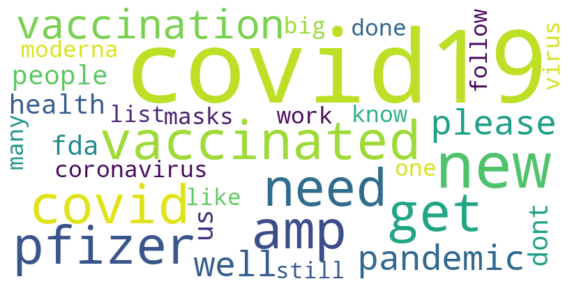

In [ ]:
a = output_mostPopularItemInABasket.to_string()


stopwords_wordcloud = stopwords.words("english") 
add= ["itemsfreq"]
stopwords_wordcloud.extend(add)

wc = WordCloud(background_color='white', width=800, height=400, max_words=200,stopwords = stopwords_wordcloud).generate(str(a).replace(" ",""))

plt.figure(figsize=(10, 10))

plt.imshow(wc, interpolation='bilinear')

plt.axis('off')

plt.show()

In [ ]:
from pyspark.ml.fpm import PrefixSpan
from pyspark.sql import Row
prefixSpan = PrefixSpan()
prefixSpan.getMaxLocalProjDBSize()
prefixSpan.getSequenceCol()
prefixSpan.setMinSupport(0.02)
prefixSpan.setMaxPatternLength(5)
prefixSpan.setSequenceCol("item")
from pyspark.sql.functions import array
baskets_a = baskets.withColumn("item", array(baskets["items"]))
prefixSpan.findFrequentSequentialPatterns(baskets_a).toPandas().to_excel(base_path + "output_prefixSpan_vaccines.xlsx")